# Examine The Blocking and Matcher Results from experiments

In [1]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score,roc_auc_score, auc
from evaluation_functions import *


# TODO: work out how to genearted matching results when using LSH as a matcher
# TODO validate metrics like end to end recall
result = pickle.load(open("../results/magellan_Jul_20_2017.p","rb"))
blocking_results = blocking_results_with_meta(result)
matcher_results = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df)


result = pickle.load(open("../results/deep_matcher_Jul_22_2347.p","rb"))
matcher_results_deep = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True)

result = pickle.load(open("../results/deep_matcher_hybrid_Jul_23_1630.p","rb"))
matcher_results_deep_hybrid = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True)

matcher_results = pd.concat([matcher_results,matcher_results_deep,matcher_results_deep_hybrid])
# Mergin results
all_results = pd.merge(matcher_results, blocking_results,left_index = True, right_index = True, suffixes = ("_m","_b"))

all_results["best_case_overall_recall"] = all_results.test_recall_b * all_results.test_recall_m.apply(np.max)



# Questions I need To answer


* Which blocking algorithm recalls the best?
* Do the algorithms which recall the best create dataset sizes that are manageable?

* Does sampling iteratively improve final precision and recall?
* Which model is the best to use as a matcher?

* Which set of systems is the most robust/easiest for the layman?


# Evaluate Blocking Performance

## Recall

In [83]:
blocking_results["id"] = blocking_results.index

blocking_stats = {"value":[np.mean,np.std]}

print(blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["id","blocking_algo","sampler"]).agg(blocking_stats).columns)
# Compute Top 5 wrt blocking recall
top_5_blocking_recall = blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["id","blocking_algo","sampler"]).agg(blocking_stats).nlargest(5,('value', 'mean'))


top_5_blocking_recall


MultiIndex([('value', 'mean'),
            ('value',  'std')],
           )


value          
                                                        mean       std
id                         blocking_algo sampler                      
iterativelshNANA85000      lsh           iterative  0.970112  0.006510
iterativelshNANA82500      lsh           iterative  0.795007  0.036244
iterativesequential801NANA sequential    iterative  0.786180  0.060992
iterativesequential802NANA sequential    iterative  0.739003  0.043922
naivelshNANA85000          lsh           naive      0.640111  0.404797

The LSH algorithm with large BIN sizes recalls the best. This is the mean. How does the sampling method affect variance of recall across sets?
Below is across ALL hyper-parameter choices

In [90]:
blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["blocking_algo","sampler"]).agg(blocking_stats)

value          
                             mean       std
blocking_algo sampler                      
lsh           iterative  0.882560  0.098696
              naive      0.585884  0.333292
sequential    iterative  0.430650  0.213380
              naive      0.276725  0.207957

We can see above that irrespective of tuning hyper-parameters, for the blocking algorithms explored in this research, our iterative sampler has successfully managed to balance performance across all sets with comparable and heavily decreased in the case of LSH, std.


In [ ]:
sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.valid_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.test_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

## Pruning Power

Measure the percentage reduction from the total possible number of comparisons. Measures how computationally friendly each method is.

Raw Pruning

Average rate of recall increase with decreasing pruning power (across hyper-parameters per method)

In [22]:
blocking_results.melt(id_vars = ["blocking_algo"], value_vars = ["train_prune","valid_prune","test_prune"])



,blocking_algo,variable,value
0,lsh,train_prune,0.994139
1,lsh,train_prune,0.938042
2,sequential,train_prune,0.826526
3,sequential,train_prune,0.982652
4,sequential,train_prune,0.997322
5,sequential,train_prune,0.819268
6,sequential,train_prune,0.978821
7,sequential,train_prune,0.995683
8,sequential,train_prune,0.817281
9,sequential,train_prune,0.977109


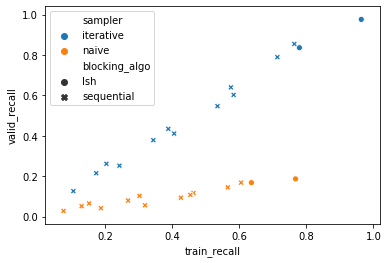

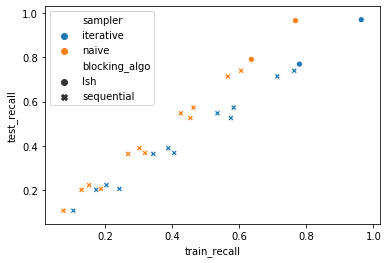

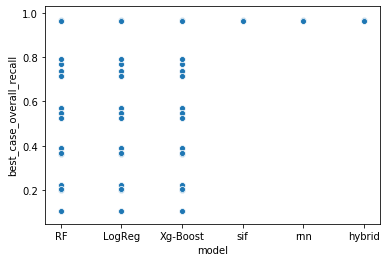

In [4]:
# Visualise some results




matcher_results.groupby(["sampler","blocking_algo"]).apply(np.mean)
matcher_results.groupby(["model","sampler","blocking_algo"]).apply(np.mean)
#NB
matcher_results.query("blocking_algo == 'lsh'").groupby(["model","sampler"]).apply(np.mean)



sns.scatterplot(x = all_results.model, y = all_results.best_case_overall_recall)

#print(all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall"]].sort_values("best_case_overall_recall", ascending = False))


# Plot top 3 and bottom 3 precision recall curves
top_3 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m"]].nlargest(3,"best_case_overall_recall")
bottom_3 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m"]].nsmallest(3,"best_case_overall_recall")

#Note the use of explode
plotting_data = pd.concat([top_3,bottom_3])
plotting_data["id"] = np.arange(plotting_data.shape[0])
#plotting_data = pd.melt(plotting_data, id_vars = ["id","sampler_m","blocking_algo_m","model"], value_vars=["test_precision","test_recall_m"]).explode("value")
# plotting_data.reset_index(inplace = True)
# plotting_data.value = plotting_data.value.astype(float)


#tt = plotting_data.pivot_table(index=[plotting_data.index,plotting_data.id],columns='variable',values='value',fill_value=0)

#sns.lineplot(data =tt, x = "test_precision", y = "test_recall_m", hue = np.array(tt.index.get_level_values(1)))







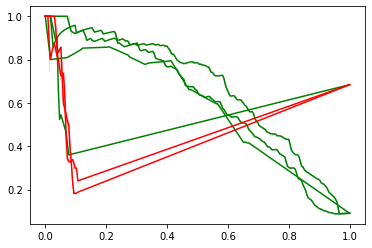

In [7]:
for id_val in np.arange(plotting_data.shape[0]):
    if (id_val <=plotting_data.shape[0]/2):
        colour = "green"
    else:
        colour = "red"
    ax = sns.lineplot(y = "test_precision" , x = "test_recall_m", data = plotting_data.iloc[id_val,:], color = colour)
plt.show()


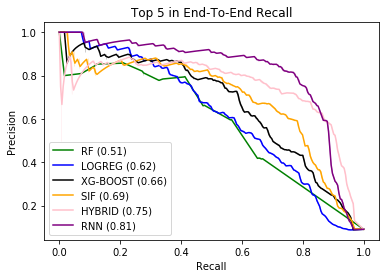

In [14]:
# Plot only top 6
top_6 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m","test_average_precision"]].nlargest(6,"best_case_overall_recall")
colours = {"RF":"green","LogReg":"blue","Xg-Boost":"black","sif":"orange","rnn":"purple","hybrid":"pink"}
top_6 = top_6.sort_values("test_average_precision")
top_6["id"] = np.arange(top_6.shape[0])

for id_val in top_6.id:

    model_name = top_6.ix[id_val,"model"]
    #print(model_name)
    avg_precision  = round(top_6.iloc[id_val,:].test_average_precision,2)
    label_val = f"{model_name.upper()} ({avg_precision})"

    ax = sns.lineplot(y = "test_precision" , x = "test_recall_m", data = top_6.iloc[id_val,:], color = colours[model_name], label = label_val)
ax.set(ylabel="Precision", xlabel = "Recall", title = "Top 5 in End-To-End Recall")
plt.show()

When you are reducing the threshold, you will never decrease the recall (you can only flag more of the positive examples as positive). Precision is looking at all the examples that you flag positively, and of those the fraction that are truly positive. This means when you are reducing the threshold, you might not add any true positives but only false positives, thereby lowering your precision. Let's take a look at a fabricated example, where P is positive and N is negative. The samples are ranked by score/probability. Everything before the threshold is flagged as positive: